In [1]:
import datetime as dt
from t_spread_curve import SpreadCurve
from strategy_backtest import Strategy

In [2]:
tickers = ['AAPL', 'AMZN', 'IBM', 'MSFT', 'WMT']
x_var = 'duration'
features = [f'log_{x_var}', x_var, 'coupon']
spread_curve = SpreadCurve(tickers, features, 't_spread',x_var)

In [3]:
random_dates = spread_curve.bond_data.date.unique()[::15]

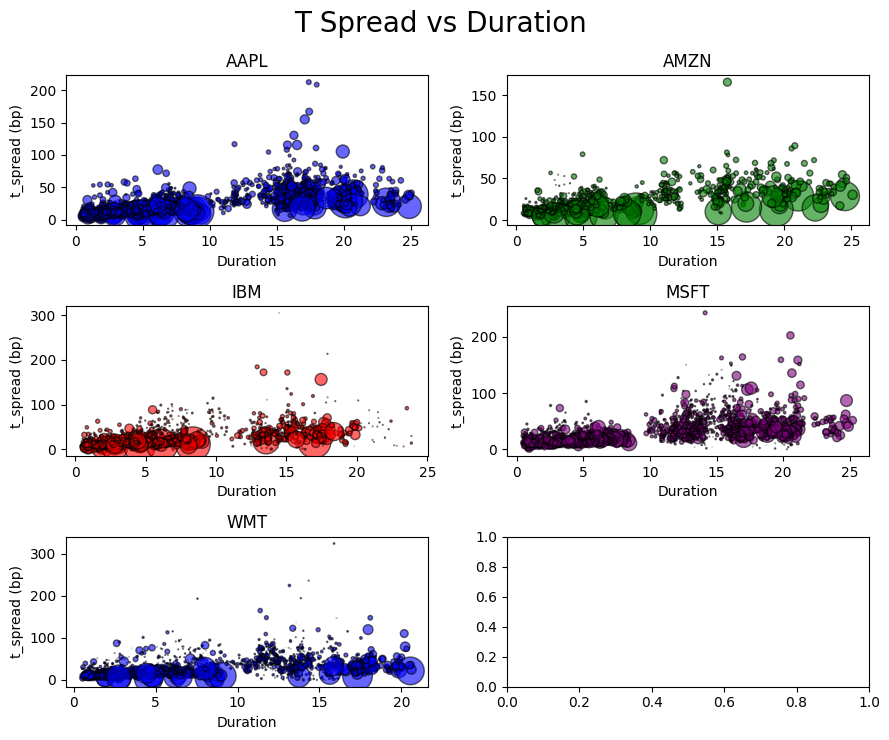

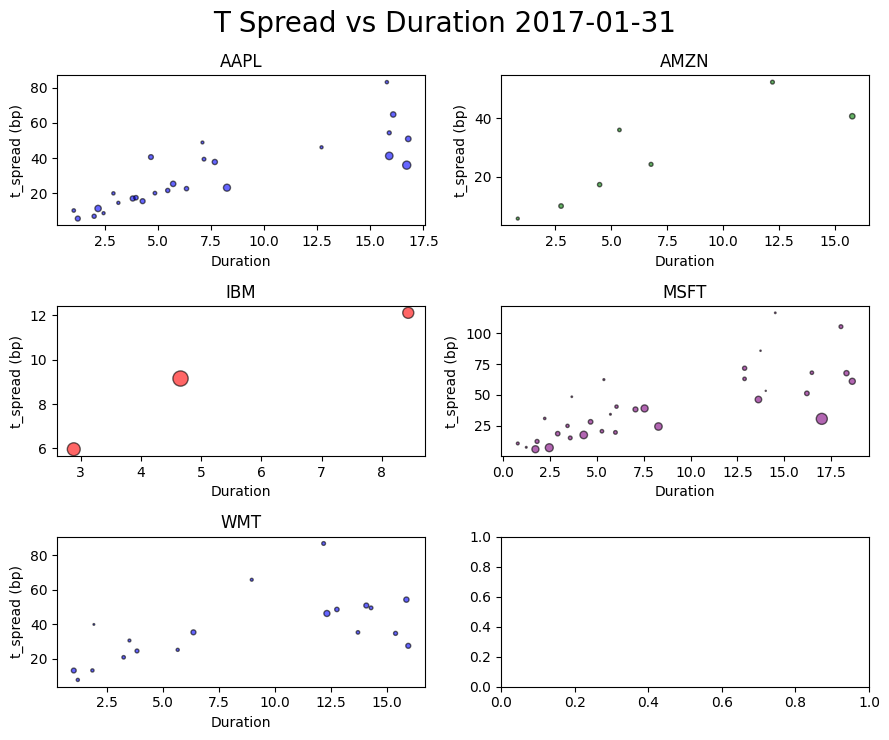

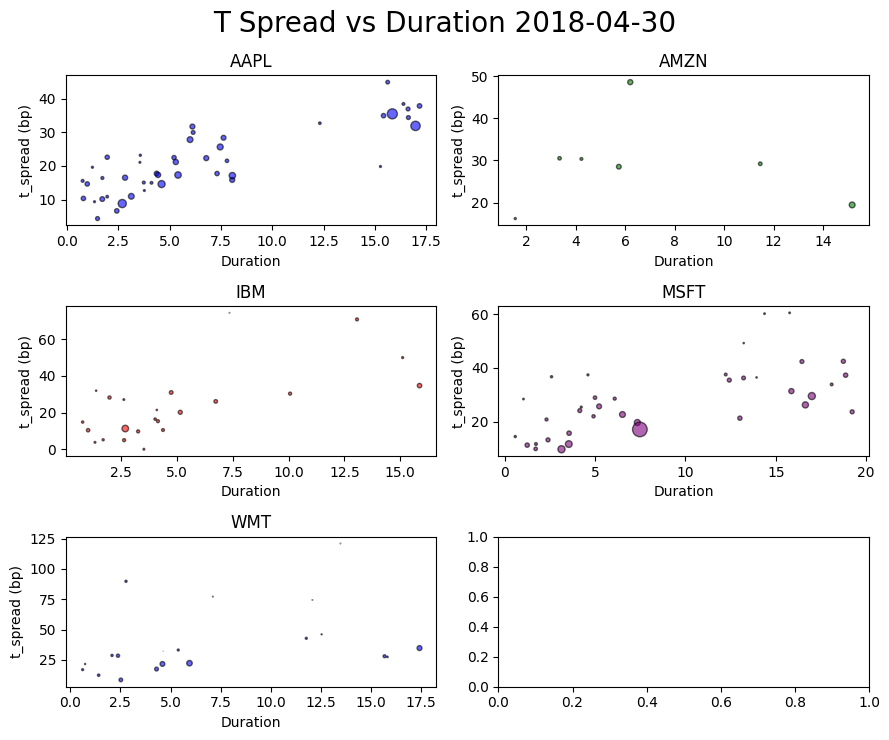

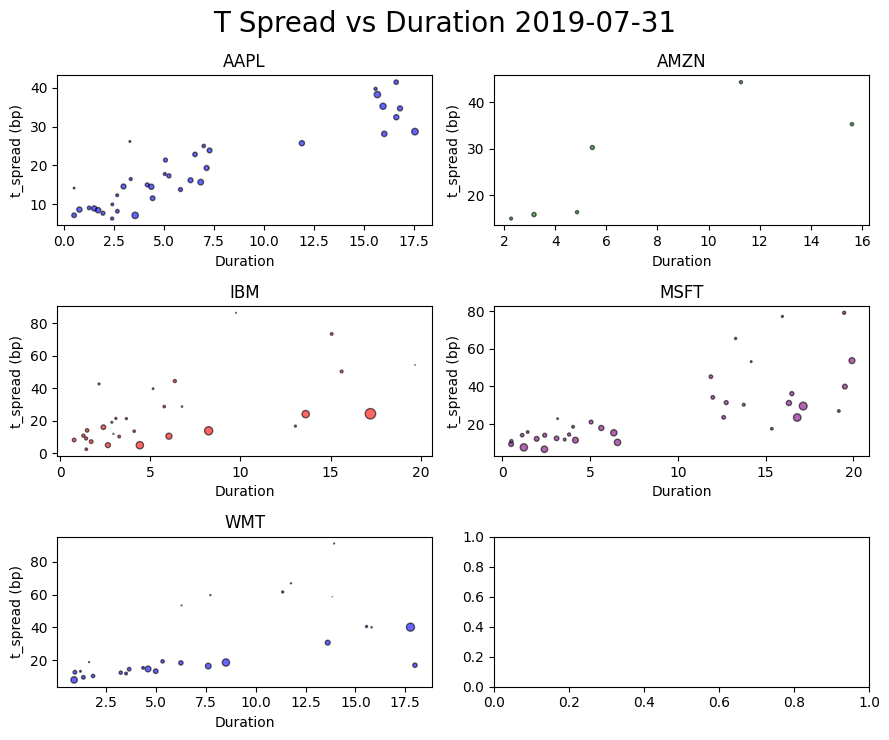

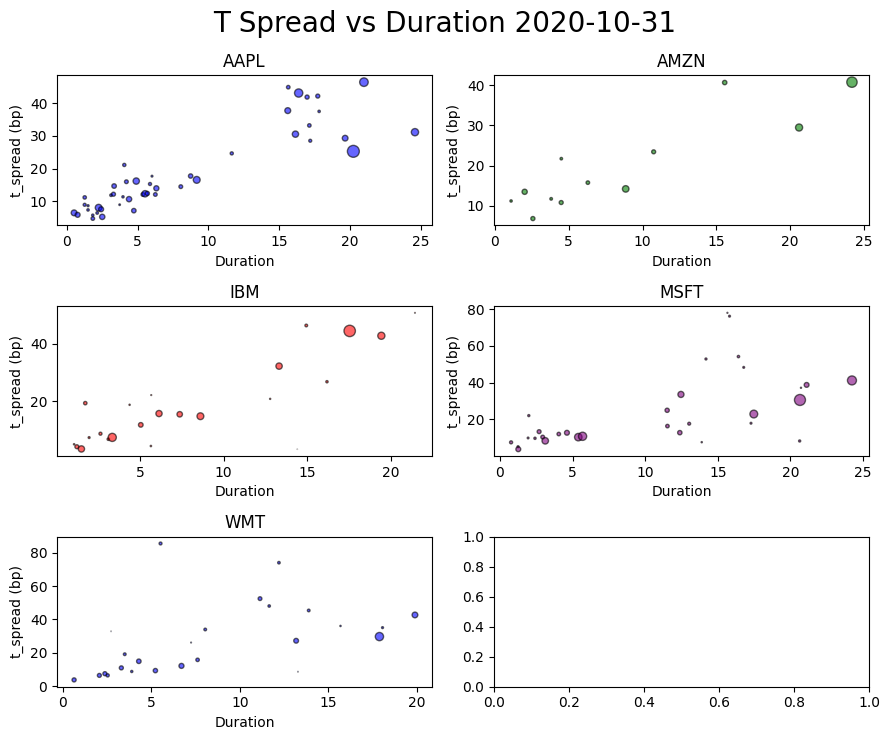

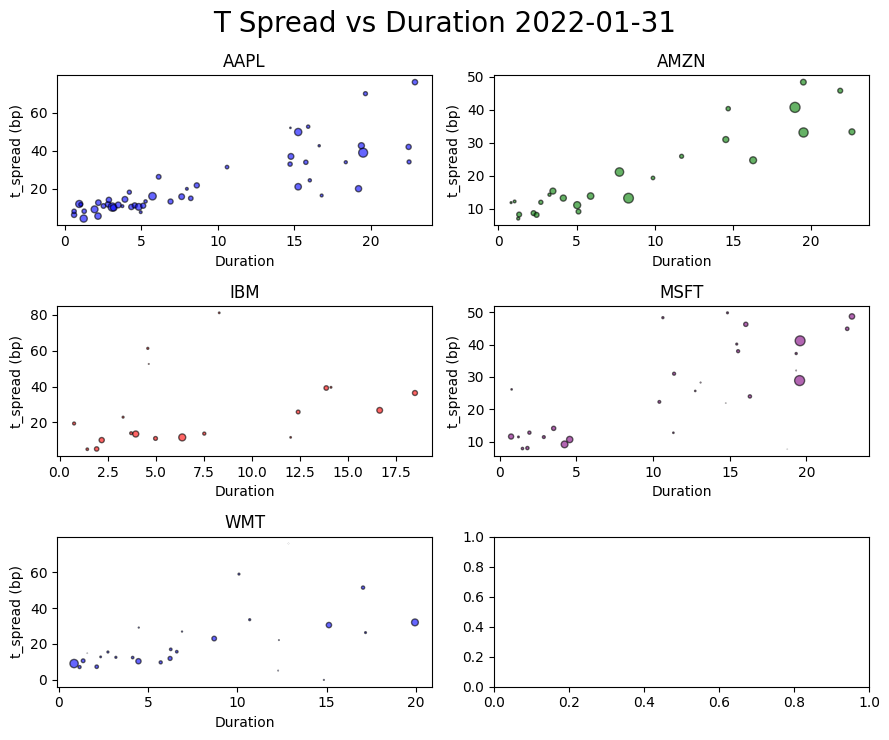

In [4]:
spread_curve.t_spread_plots()

for d in random_dates:
    spread_curve.t_spread_plots(d)

In [5]:
spread_curve.fit('amount_outstanding')

In [ ]:
for d in random_dates:
    spread_curve.plot_fitted_vs_actual(d)

In [7]:
bond_data = spread_curve.bond_data[['date', 'isin', 'company_symbol', 'duration', 'dirty_price', 't_spread_fitted', 't_spread']].copy()
bond_data.eval('t_spread_resid = t_spread- t_spread_fitted', inplace=True)

In [ ]:
bond_data = spread_curve.bond_data[['date', 'isin', 'company_symbol', 'duration', 'dirty_price', 't_spread_fitted', 't_spread']].copy()
bond_data.eval('t_spread_resid = t_spread- t_spread_fitted', inplace=True)

# Instantiate the class with the bond data
strategy = Strategy(bond_data, 20)

# Run the strategy
strategy.run_strategy('duration_based')

# Calculate the performance metrics
performance_metrics = strategy.calculate_performance() 

# Display the performance metrics
print(performance_metrics)

# Plot cumulative returns for each company
strategy.plot_performance() 
